In [2]:
import random
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn import preprocessing
import nltk
import csv
import re
import math
from pprint import pprint
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


import networkx as nx
from networkx import betweenness_centrality
from networkx import edge_betweenness_centrality
from networkx import load_centrality
from networkx import eigenvector_centrality

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore

import en_core_web_sm

%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_set = pd.read_csv('/content/drive/MyDrive/DSBA M2/2 MLNS/Kaggle/my own work/temp_train_set_March_20.csv')
test_set = pd.read_csv('/content/drive/MyDrive/DSBA M2/2 MLNS/Kaggle/my own work/temp_test_set_March_20.csv')

In [4]:
train_set.head()

,Unnamed: 0,source_id,target_id,label,source_authors,target_authors,publication_year_diff,source_journal,target_journal,same_journal,...,5_target.1,6_target.1,7_target.1,8_target.1,9_target.1,10_target.1,11_target.1,12_target.1,13_target.1,14_target.1
0,0,9510123,9502114,1,NaN,"['w. kim', 'j. lee', 'y. park']",0.0,Phys.Lett.,Phys.Lett.,1,...,0.001503,0.011897,0.003587,0.000744,-0.001170,0.006011,0.001121,-0.001973,0.003986,0.001878
1,1,9707075,9604178,1,"['l.e.ibanez', 'a.m.uranga']","['a. dabholkar', 'j. park']",1.0,NaN,Nucl.Phys.,0,...,0.001010,0.008056,0.002458,0.000512,-0.000806,0.004159,0.000779,-0.001373,0.002784,0.001315
2,2,9312155,9506142,0,"['p. kleban', 'i. vassileva']",['v. moretti'],-2.0,Phys.Rev.Lett.,Class.Quant.Grav.,0,...,-0.025941,-0.351140,0.871733,0.044678,-0.058764,0.176609,0.022999,-0.036765,0.063519,0.025810
3,3,9911255,302165,0,"['p. argyres', 's. pell,']",['t. hollowood'],-4.0,JHEP,NaN,0,...,-0.007274,-0.066396,-0.026406,-0.006121,0.009934,-0.059091,-0.013188,0.024863,-0.057807,-0.032618
4,4,9701033,209076,0,NaN,"['e. gravanis', 's. willison']",-5.0,Phys.Lett.,NaN,0,...,-0.007274,-0.066396,-0.026406,-0.006121,0.009934,-0.059091,-0.013188,0.024863,-0.057807,-0.032618


In [5]:
# get some elements and then assign the attributes
# 从别的地方抄的

def shortest_path_info(some_graph, source, target):
    if source not in some_graph.nodes():
        return -1  # not known

    if target not in some_graph.nodes():
        return -1  # not known

    if nx.has_path(some_graph, source, target):
        return nx.dijkstra_path_length(some_graph, source=source, target=target)

    return -2  # no path

In [6]:
def degree_centrality(some_graph):
    degree_dict = dict(some_graph.degree(some_graph.nodes()))
    return degree_dict

In [7]:
def get_in_out_degree(some_graph):
    in_degree_dict = dict(some_graph.in_degree(some_graph.nodes()))
    out_degree_dict = dict(some_graph.out_degree(some_graph.nodes()))
    return in_degree_dict, out_degree_dict

In [8]:
def common_neighs(some_graph, x, y):
    if x not in some_graph.nodes():
        return 0, []  # not known 
    if y not in some_graph.nodes():
        return 0, []  # not known
    neighs = sorted(list(nx.common_neighbors(some_graph, x, y)))
    return len(neighs), neighs

In [9]:
def jac_index(g, x, y):
    if x not in g.nodes():
        return -1  # not known 
    if y not in g.nodes():
        return -1  # not known
    preds = nx.jaccard_coefficient(g, [(x, y)])
    jacc = 0

    for u, v, p in preds:
        jacc = p
    return jacc

In [10]:
def pref_attachement(g, x, y):
    if x not in g.nodes():
        return -1  # not known 
    if y not in g.nodes():
        return -1  # not known
    preds = nx.preferential_attachment(g, [(x, y)])
    pref = 0

    for u, v, p in preds:
        pref = p
    return pref

In [11]:
def aa_index(g, x, y):
    if x not in g.nodes():
        return -1  # not known 
    if y not in g.nodes():
        return -1  # not known
    preds = nx.adamic_adar_index(g, [(x, y)])
    aa = 0

    for u, v, p in preds:
        aa = p
    return aa 

In [12]:
# create the network 
# get network for when there is a connection in train set
# edges = list(zip(train_set.loc[train_set.label == 1].source_id, train_set.loc[train_set.label == 1].target_id))
# nodes = list(set(train_set.source_id + train_set.target_id))

# train_G = nx.DiGraph()
# train_G.add_nodes_from(nodes)
# train_G.add_edges_from(edges)

train_G = nx.from_pandas_edgelist(train_set, 
                                  source='source_id', 
                                  target='target_id', 
                                  edge_attr=None,
                                  create_using=nx.DiGraph())

# make sure you also have an undirected graph
train_G_ud = train_G.to_undirected()

# create some dictionaries to use later on
clustering_coeff_dict = nx.clustering(train_G_ud)
avg_neigh_degree_dict = nx.average_neighbor_degree(train_G)
out_degree_centrality = nx.out_degree_centrality(train_G)
in_degree_centrality = nx.in_degree_centrality(train_G)
page_rank = nx.pagerank(train_G)
hub_score, authority_score = nx.hits(train_G)

In [13]:
# function to get features for graph of a single element
def get_features(directed_graph, ud_graph, source_id, target_id, label):
    # features for undirected graph
    jaccard_index = jac_index(ud_graph, source_id, target_id)
    preferencial_attachment = pref_attachement(ud_graph, source_id, target_id)
    number_common_neighbours, common_neighbours = common_neighs(ud_graph, source_id, target_id)
    adamic_adar_index = aa_index(ud_graph, source_id, target_id)
    #shortest_path = shortest_path_info(train_G, source_id, target_id)

    source_pr = page_rank[source_id]
    source_hub_score = hub_score[source_id]
    source_authority_score = authority_score[source_id]
    source_cluster_coeff = clustering_coeff_dict[source_id]
    source_out_centrality = out_degree_centrality[source_id]
    source_avg_neigh_degree = avg_neigh_degree_dict[source_id]
 
    target_pr = page_rank[target_id]
    target_hub_score = hub_score[target_id]
    target_authority_score = authority_score[target_id]
    target_cluster_coeff = clustering_coeff_dict[target_id]
    target_in_centrality = in_degree_centrality[target_id]
    target_avg_neigh_degree = avg_neigh_degree_dict[target_id]

    # no name feature but supposedly important 
    feature_n = source_out_centrality * target_in_centrality
     
    return [source_id, target_id, label, jaccard_index, preferencial_attachment, 
            number_common_neighbours, adamic_adar_index, source_pr, target_pr, 
            source_hub_score, target_hub_score, source_authority_score, 
            target_authority_score, source_cluster_coeff, target_cluster_coeff, 
            source_out_centrality, target_in_centrality, source_avg_neigh_degree, 
            target_avg_neigh_degree, feature_n]

In [14]:
# 这里，把上面def的return的值全部设置成新的columns
### add columns when you add Features
column_names = ['source_id', 
                'target_id', 
                'label', 
                'jaccard_index', 
                'preferential_attachement', 
                'number_common_neighbours',  
                'adamic_adar_index', 
                'source_pr',
                'target_pr', 
                'source_hub_score', 
                'target_hub_score', 
                'source_authority_score',
                'target_authority_score', 
                'source_cluster_coeff', 
                'target_cluster_coeff',
                'source_out_centrality', 
                'target_in_centrality', 
                'source_avg_neigh_degree', 
                'target_avg_neigh_degree',
                'feature_n']

final_train_set = pd.DataFrame([[np.nan] * len(column_names)] * train_set.shape[0], 
                               columns=column_names)
final_test_set = pd.DataFrame([[np.nan] * len(column_names)] * test_set.shape[0], 
                              columns=column_names)

In [15]:
# create the features for the train set
for idx, row in tqdm(train_set.iterrows()):
    features = get_features(train_G, train_G_ud, row.source_id, row.target_id, row.label)
    #update the features
    final_train_set.loc[idx] = features

#create the features for the test set
for idx, row in tqdm(test_set.iterrows()):
    features = get_features(train_G, train_G_ud, row.source_id, row.target_id, -1)
    #update the features
    final_test_set.loc[idx] = features

615512it [07:36, 1349.34it/s]
32648it [00:32, 1001.37it/s]


In [16]:
# merge graph and text features together 
train_set = train_set.merge(final_train_set, 
                            on=['source_id', 'target_id', 'label'], 
                            how='left') 

test_set = test_set.merge(final_test_set, 
                          on=['source_id', 'target_id'], 
                          how='left')

In [17]:
# 再把nan去掉
train_set.publication_year_diff.fillna(-24, inplace=True) # 24 is for unknown (?)
train_set.fillna('unknown', inplace=True)
test_set.publication_year_diff.fillna(-24, inplace=True) # 24 is for unknown (?_)
test_set.fillna('unknown', inplace=True)

In [18]:
train_set.to_csv('/content/drive/MyDrive/DSBA M2/2 MLNS/Kaggle/my own work/temp_before_graph_features_train_set_March_20.csv',
                 index=False)
test_set.to_csv('/content/drive/MyDrive/DSBA M2/2 MLNS/Kaggle/my own work/temp_before_graph_features_test_set_March_20.csv', 
                 index=False)

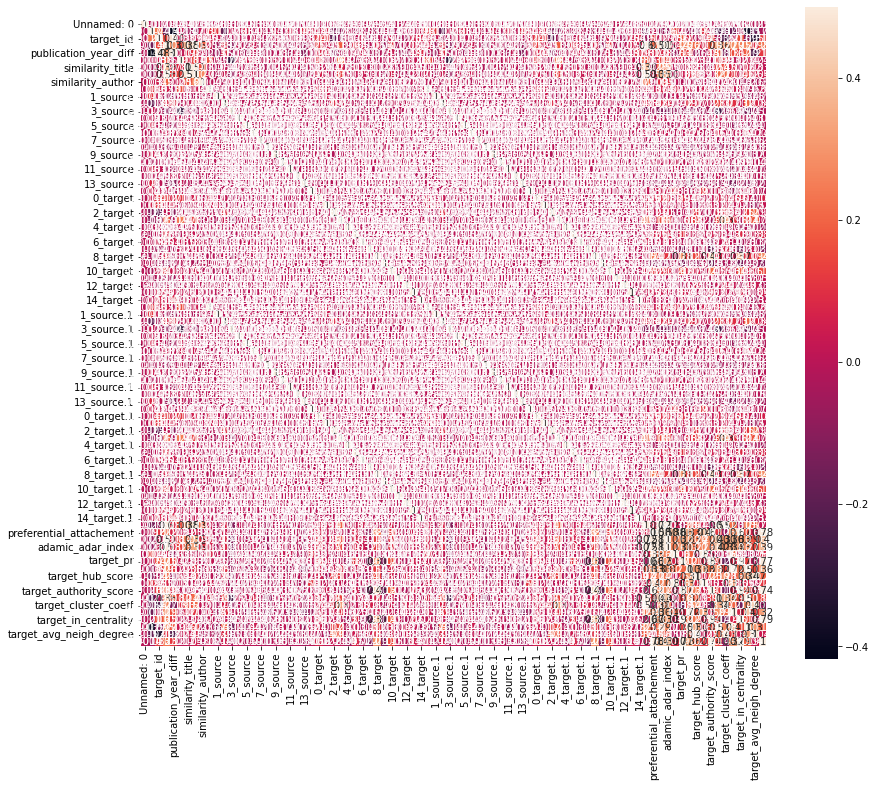

In [19]:
# 随意看一下
%matplotlib inline
## Most interesting correlation is with label
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,12))
sns.heatmap(train_set.corr(),
            vmax=0.5,
            square=True,
            annot=True)

## Test Split

In [60]:
train_set = pd.read_csv('/content/drive/MyDrive/DSBA M2/2 MLNS/Kaggle/my own work/temp_before_graph_features_train_set_March_20.csv')
test_set = pd.read_csv('/content/drive/MyDrive/DSBA M2/2 MLNS/Kaggle/my own work/temp_before_graph_features_test_set_March_20.csv')

In [62]:
# separate features from labels:
X = train_set.loc[:, (train_set.columns != 'label') & 
                     (train_set.columns != 'common_authors') & 
                     (train_set.columns != 'source_authors') & 
                     (train_set.columns != 'target_authors') & 
                     (train_set.columns != 'source_journal') & 
                     (train_set.columns != 'target_journal')]
y = train_set['label']
# y.astype(int)

In [ ]:
# # final feature correlation
# ff = X.copy()
# ff['label'] = y
# plt.figure(figsize=(14,12))
# sns.heatmap(X.corr(),
#             vmax=0.5,
#             square=True,
#             annot=True)

In [46]:
# # 去掉unnamed
# train_set2 = train_set.iloc[:, 1:]
# test_set2 = test_set.iloc[:, 1:]

In [ ]:
train_set2.head()

In [54]:
test_set2['label']

0       -1.0
1       -1.0
2       -1.0
3       -1.0
4       -1.0
        ... 
32643   -1.0
32644   -1.0
32645   -1.0
32646   -1.0
32647   -1.0
Name: label, Length: 32648, dtype: float64

In [55]:
train_set2['label']

0         1
1         1
2         0
3         0
4         0
         ..
615507    1
615508    0
615509    0
615510    1
615511    1
Name: label, Length: 615512, dtype: int64

##  XGB

In [63]:
test_set.shape

(32648, 90)

In [64]:
test = test_set.loc[:, (test_set.columns != 'label') & 
                        (test_set.columns != 'common_authors') & 
                        (test_set.columns != 'source_authors') & 
                        (test_set.columns != 'target_authors') & 
                        (test_set.columns != 'source_journal') & 
                        (test_set.columns != 'target_journal')]

In [65]:
# making sure the test and the train files have same sequence of columns

# test = test[X.columns]

from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate

# defining the base model
xgb_model_base = XGBClassifier(n_estimators = 100)

# printing the cross validation scores for the classifier
scores = cross_validate(xgb_model_base, X, y.values.ravel(), 
                        scoring='f1', 
                        cv=3,
                        n_jobs = -1,
                        verbose=True) # n_jobs is the number of cpus to use -1 => all

# fitting on the training data
xgb_model_base.fit(X, y.values.ravel())


# predicting the outcome from the final 
predictions = xgb_model_base.predict(test)

# write out
out_df = test_set.copy()
data = {'id': list(out_df.index), 'category': predictions}
final_df = pd.DataFrame(data)


# 3: write file out
final_df.to_csv('submission.csv',index=False, sep=',')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.6min finished


In [67]:
# defining the search grid
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from xgboost.sklearn import XGBClassifier

xgb_regressor = xgb.XGBRegressor(verbose=True)

random_grid = {
     "n_estimators"     : [int(x) for x in np.linspace(50, 600, num = 20)],
     "learning_rate"    : [0.01, 0.02, 0.05, 0.10 ] ,
     "max_depth"        : [ 6, 8, 10, 12, 15, 20],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.3, 0.4, 0.7, 0.9 ],
     "colsample_bytree" : [ 0.05, 0.1, 0.3, 0.4]}

# Use the random grid to search for best hyperparameters

# First create the base model to tune
xgb_model = XGBClassifier()

# Random search of parameters
xgb_random = RandomizedSearchCV(estimator = xgb_model, 
                                param_distributions = random_grid,
                                n_iter = 10, 
                                cv = 3, 
                                verbose=2, 
                                random_state=9,
                                n_jobs = -1, 
                                scoring = 'f1_weighted')

xgb_random.fit(X, y.values.ravel())
optimised_xgb_random = xgb_random.best_estimator_

print('random search best parameter is: ', optimised_xgb_random)

# printing the cross validation scores for the classifier
scores = cross_validate(optimised_xgb_random, X, y.values.ravel(), 
                        scoring='f1', 
                        cv=3,
                        n_jobs = -1, 
                        verbose=True) # n_jobs is the number of cpus to use -1 => all


# fitting on the training data
xgb_model.fit(X, y.values.ravel())

# predicting the outcome from the final 
predictions_xgb_random = optimised_xgb_random.predict(test)

# write out
out_df = test_set.copy()
data = {'id': list(out_df.index), 'category': predictions}
final_df = pd.DataFrame(data)


# 3: write file out
final_df.to_csv('/content/drive/MyDrive/DSBA M2/2 MLNS/Kaggle/my own work/submission_XGB_March_20_1.csv', index=False, sep=',')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


random search best parameter is:  XGBClassifier(colsample_bytree=0.4, gamma=0.4, learning_rate=0.02, max_depth=12,
              min_child_weight=5, n_estimators=194)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 26.4min finished


## SVM

In [ ]:
from sklearn.svm import LinearSVC

# SVM has a zero tolerance towards null values, hence replacing them by 0

XVM = X.fillna(value=0)
test_SVM = test.fillna(value=0)

clf = LinearSVC( tol=1e-4)


# printing the cross validation scores for the classifier
scores = cross_validate(clf, XVM, y, scoring='f1', 
                        cv=10,n_jobs = -1 ) # n_jobs is the number of cpus to use -1 => all
scores


# fitting on the training data
clf.fit(XVM, y)

# predicting the outcome from the final 
prediction_clf = clf.predict(test_SVM)

# write out
out_df = test_set.copy()
data = {'id': list(out_df.index), 'category': predictions}
final_df = pd.DataFrame(data)


# 3: write file out
final_df.to_csv('/content/drive/MyDrive/DSBA M2/2 MLNS/Kaggle/my own work/submission_SVM_March_20_1.csv',index=False, sep=',')

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# 1: retrain the complete model -> don't forget to change this to optimal one @ end
final_model = RandomForestClassifier()
final_model.fit(X, y)

# 2: predict on the test set
final_test_set = test_set.loc[:,(test_set.columns != 'source_authors') & 
                                (test_set.columns != 'common_authors') & 
                                (test_set.columns != 'target_authors') & 
                                (test_set.columns != 'label') & 
                                (test_set.columns != 'source_journal') & 
                                (test_set.columns != 'target_journal')]
predictions = final_model.predict(final_test_set)

# write out
out_df = test_set.copy()
data = {'id': list(out_df.index), 'category': predictions}
final_df = pd.DataFrame(data)


# 3: write file out
final_df.to_csv('/content/drive/MyDrive/DSBA M2/2 MLNS/Kaggle/my own work/submission_RF_March_20_1.csv',index=False, sep=',')

# plot the feature importance
feat_importances = pd.Series(final_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()